<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/17_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries
- classification: Is the visitor of the website a bot or human?
- event detection: Hotword detection - "Hey Alexa."
- anomaly detection: Is something unusual happening?

In [ ]:
# Lets forecast temperature

# Get data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-05-19 11:24:24--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.132.192, 16.182.43.56, 16.182.103.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.132.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  6.39MB/s    in 2.0s    

2025-05-19 11:24:26 (6.39 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


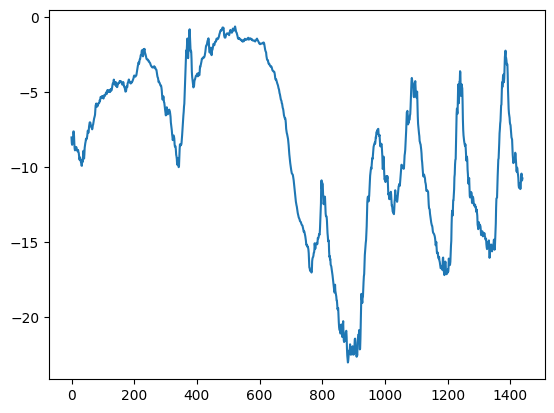

In [ ]:
# Familiarize us with the data
import os
import numpy as np

from matplotlib import pyplot as plt

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


# Convert to numpy array
temperature = np.zeros(len(lines,))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]] # discard Date Time
  temperature[i] = values[1]
  raw_data[i, :] = values[:] # features


# Narrow the Graph to the first 1- days: 24 * 6 = 144 (one day)
plt.plot(range(1440), temperature[:1440])

In [ ]:
# prep data
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
from tensorflow import keras

# Normalize data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Create Dataset
"""
Simple example: [0 1 2 3 4 5 6]
Sequence length = 3 --> [1 2 3] [2 3 4] [3 4 5] [4 5 6]
Target should be the same array as the  data, offset by some amount:

[0, 1, 2] Target is 3
[1, 2, 3] Target is 4
"""

sampling_rate = 6 # One data point per hour, due to temp not chaning much every 10 min
sequence_length = 120 # will go back 5 days, e.g 120 hours
delay = sampling_rate * (sequence_length + 24 - 1) # Target will be the temp 24 after
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [24]:
import numpy as np

# Fake data
total_timesteps = 5000
data = np.arange(total_timesteps)

def get_batch(data, start_indicies, sequence_length, sampling_rate, delay):
  """
  Implementing the get batch function to understand what is happening in the training loop.
  This function build a batch from current index
  Input: sequence_length values spaced by sampling rate
  Target: values at start_index + delay
  """
  x = []
  y = []

  for idx in start_indicies:
    """
    sequence_length = 5
    sampling_rate = 2
    idx = 10

    example:
    We want to extract the data
    data[10], data[12], data[14], data[16], data[18]

    THese positions are:
    10 + 0*2
    10 + 1*2
    10 + 2*2
    10 + 3*2
    10 + 4*2

    For the Target:
    sequence_length - 1: because it is zero indexed.

    Off by one error.
    idx + (sequence_length - 1) * sampling_rate
    10 + (5 - 1) * 2
    10 + 4 * 2
    18

    We want data[20], so add + 1
    end_idx = idx + (sequence_length - 1) * sampling_rate + 1
    10 + (5 - 1)* 2 + 1
    10 + 8 + 1
    19


    data[10 : 19 : 2]
    """
    end_idx = idx + sampling_rate * (sequence_length - 1) + 1
    target_idx = idx + delay
    if end_idx > len(data) or target_idx >= len(data):
        continue  # Skip if input sequence or target is out of bounds

    sequence = data[idx: end_idx : sampling_rate]
    target = data[target_idx]
    x.append(sequence)
    y.append(target)

  return np.array(x), np.array(y)

In [25]:
# Simulate training steps
sequence_length = 10
sampling_rate = 2
delay = sampling_rate * sequence_length
batch_size = 256

# Random starting indices (simulate shuffling)
np.random.seed(42)
"""
Goal: build random starting points, so that we can build sequences of a certain
length and look ahead a certain delay for the target!

Example:
total_timesteps = 30
sequence_length = 4
sampling_rate = 2
delay = 5
batch_size = 3

1. calculate the max start index:
idx + (sequence_length - 1) * sampling_rate
idx + (4 - 1) * 2
idx + 6

Target index: idx + delay
idx + 5

Both must be less than total_timesteps
max(idx + 6, idx + delay) < 30

So, idx + 6 < 30
Therefore idx < 24

2. Conservative caluclation to simplify, ensure safety and
onfusing interplay of delay and sampling rate
start_idx_max = total_timesteps - delay - sampling_rate * sequence_length
30 - 5 - 2*4 = 30 - 5 - 8 = 17
"""
start_indices = np.random.randint(0, total_timesteps - delay - sampling_rate * sequence_length, size=batch_size * 5)

print("Simulating 5 training steps:")
for step in range(5):
    step_indices = start_indices[step * batch_size : (step + 1) * batch_size]
    x_batch, y_batch = get_batch(data, step_indices, sequence_length, sampling_rate, delay)

    print(f"\nStep {step + 1}")
    print(f"Input shape: {x_batch.shape}")
    print(f"Target shape: {y_batch.shape}")
    print(f"Sample input (first in batch): {x_batch[0]}")
    print(f"Target for first sample: {y_batch[0]}")

Simulating 5 training steps:

Step 1
Input shape: (256, 10)
Target shape: (256,)
Sample input (first in batch): [860 862 864 866 868 870 872 874 876 878]
Target for first sample: 880

Step 2
Input shape: (256, 10)
Target shape: (256,)
Sample input (first in batch): [4735 4737 4739 4741 4743 4745 4747 4749 4751 4753]
Target for first sample: 4755

Step 3
Input shape: (256, 10)
Target shape: (256,)
Sample input (first in batch): [1542 1544 1546 1548 1550 1552 1554 1556 1558 1560]
Target for first sample: 1562

Step 4
Input shape: (256, 10)
Target shape: (256,)
Sample input (first in batch): [66 68 70 72 74 76 78 80 82 84]
Target for first sample: 86

Step 5
Input shape: (256, 10)
Target shape: (256,)
Sample input (first in batch): [3212 3214 3216 3218 3220 3222 3224 3226 3228 3230]
Target for first sample: 3232


In [ ]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
# Common-sense, non-machine learning baseline
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(120, 14))
x = layers.Reshape((120 * 14,))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 18.1966 - mae: 3.2212 - val_loss: 11.0865 - val_mae: 2.6370
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 9.2539 - mae: 2.3975 - val_loss: 11.6285 - val_mae: 2.6963
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 8.4034 - mae: 2.2826 - val_loss: 10.8277 - val_mae: 2.6047
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 68s 57ms/step - loss: 7.9509 - mae: 2.2196 - val_loss: 12.0861 - val_mae: 2.7525
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 7.6084 - mae: 2.1712 - val_loss: 10.4226 - val_mae: 2.5546
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 7.3375 - mae: 2.1316 - val_loss: 10.5722 - val_mae: 2.5777
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 7.1517 - mae: 2.1084 - val_loss: 14.6790 - val_mae: 3.0469
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 6.9720 - mae: 2.0814 - val_loss: 11.1223 - val_mae: 2.6446
Epoch 9/10
819/819 ━━━━━━━━━━━━

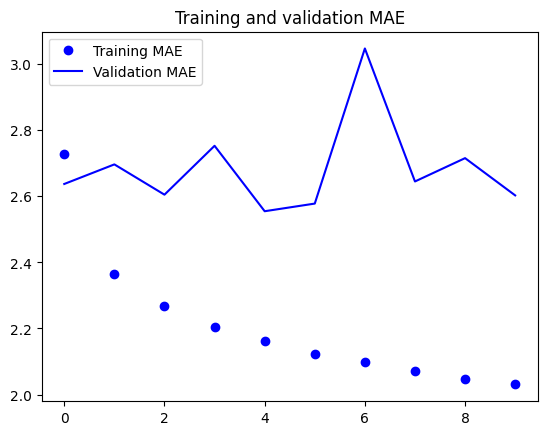

In [ ]:
from matplotlib import pyplot as plt


loss = history["mae"]
val_loss = history["val_mae"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# simple LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 130ms/step - loss: 69.1207 - mae: 6.3707 - val_loss: 12.8736 - val_mae: 2.7078
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 124ms/step - loss: 11.9350 - mae: 2.6639 - val_loss: 9.2976 - val_mae: 2.3757
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 105s 128ms/step - loss: 9.8156 - mae: 2.4445 - val_loss: 9.8649 - val_mae: 2.4462
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 125ms/step - loss: 9.2955 - mae: 2.3757 - val_loss: 9.8712 - val_mae: 2.4541
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 125ms/step - loss: 8.9822 - mae: 2.3295 - val_loss: 9.8179 - val_mae: 2.4446
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 126ms/step - loss: 8.7016 - mae: 2.2911 - val_loss: 10.3049 - val_mae: 2.5059
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 125ms/step - loss: 8.4370 - mae: 2.2528 - val_loss: 10.2388 - val_mae: 2.5032
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 125ms/step - loss: 8.2054 - mae: 2.2195 - val_loss: 10.2697 - val_mae: 2.5025
Epoch 9/10
819/819

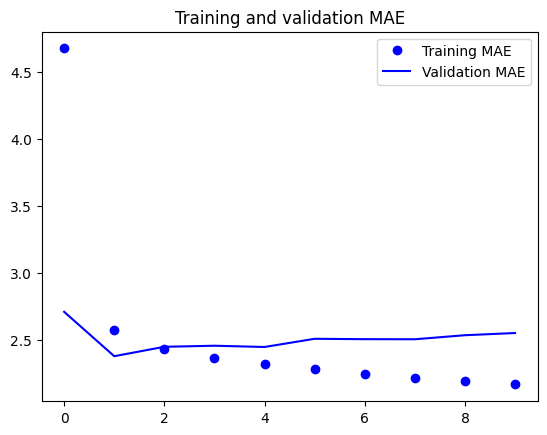

In [ ]:
loss = history["mae"]
val_loss = history["val_mae"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()